Set up the environment, importing Semantic Kernel SDK and SkiaSharp, used to display images inline.

In [2]:
#r "nuget: Microsoft.SemanticKernel, 0.9.61.1-preview"
#r "nuget: SkiaSharp"

#!import config/Settings.cs
#!import config/Utils.cs
#!import config/SkiaUtils.cs

using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.Configuration;
using Microsoft.SemanticKernel.Orchestration;
using Microsoft.SemanticKernel.KernelExtensions;
using Microsoft.SemanticKernel.AI.ImageGeneration;
using Microsoft.SemanticKernel.AI.Embeddings;
using Microsoft.SemanticKernel.AI.Embeddings.VectorOperations;

Installed Packages Microsoft.SemanticKernel, 0.9.61.1-preview SkiaSharp, 2.88.3

The notebook uses:

* **text-davinci-003** to generate a random image description
* **OpenAI Dall-E 2** to transform the image description into an image
* **text-embedding-ada-002** to compare your guess against the real image description

In [3]:
var (useAzureOpenAI, model, azureEndpoint, apiKey, orgId) = Settings.LoadFromFile();

var kernel = Microsoft.SemanticKernel.Kernel.Builder
    .Configure(c =>
    {
        c.AddOpenAIEmbeddingGeneration("ada", "text-embedding-ada-002", apiKey);
        c.AddOpenAITextCompletion("davinci", "text-davinci-003", apiKey, orgId);
        c.AddOpenAIImageGeneration("dallE", apiKey, orgId);
    })
    .Build();

var dallE = kernel.GetService<IImageGeneration>();
var textEmbedding = kernel.GetService<IEmbeddingGenerator<string, float>>();

**genImgDescription** is a Semantic Function used to generate a random image description. 
The function takes in input a random number to increase the diversity of its output.

The random image description is then given to **Dall-E 2** asking to create an image.


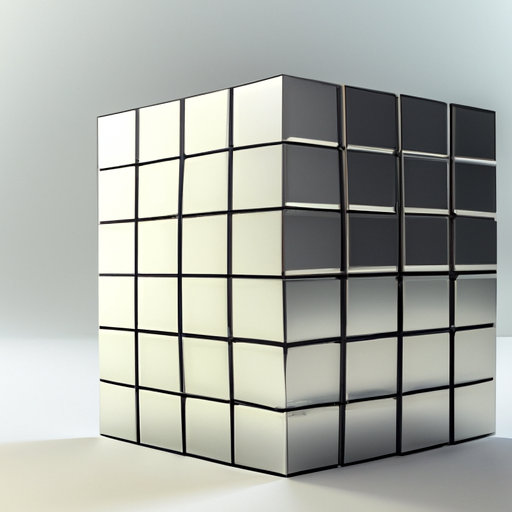

In [12]:
var genImgDescription = kernel.CreateSemanticFunction(
    "Think about an artificial object correlated to number {{$input}}. " +
    "Describe the image with one detailed sentence. The description cannot contain numbers.", 
    maxTokens: 256, temperature: 1);

var random = new Random().Next(0, 200);
var imageDescription = await genImgDescription.InvokeAsync($"{random}");

var imageUrl = await dallE.GenerateImageAsync(imageDescription.Result.Trim(), 512, 512);

await SkiaUtils.ShowImage(imageUrl, 512, 512);

Try to guess what the image is about, describing the content.

You'll get a score at the end 😉

In [ ]:
var guess = await InteractiveKernel.GetInputAsync("Describe the image in your words");

var origEmbedding = await textEmbedding.GenerateEmbeddingsAsync(new List<string> { imageDescription.Result} );
var guessEmbedding = await textEmbedding.GenerateEmbeddingsAsync(new List<string> { guess } );
var similarity = origEmbedding.First().AsReadOnlySpan().CosineSimilarity(guessEmbedding.First().AsReadOnlySpan());

Console.WriteLine($"Your description:\n{Utils.WordWrap(guess, 90)}\n");
Console.WriteLine($"Real description:\n{Utils.WordWrap(imageDescription.Result.Trim(), 90)}\n");
Console.WriteLine($"Score: {similarity:0.00}\n\n");

Console.WriteLine(imageUrl);